## Importing Libraries

In [1411]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import plotly.express as px
import numpy as np
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import LocalOutlierFactor
from matplotlib import pyplot as plt
import seaborn as sns


## Loading the Data

In [1412]:
df = pd.read_csv("Breast_Cancer.csv", header=0, delimiter=',')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


## Dataset Inspection

In [1413]:
numerical_cols = ['Age','Tumor Size','Regional Node Examined','Reginol Node Positive','Survival Months']
categorical_cols = ['Race','Marital Status','T Stage ','N Stage','6th Stage','differentiate','Grade','A Stage','Estrogen Status','Progesterone Status']

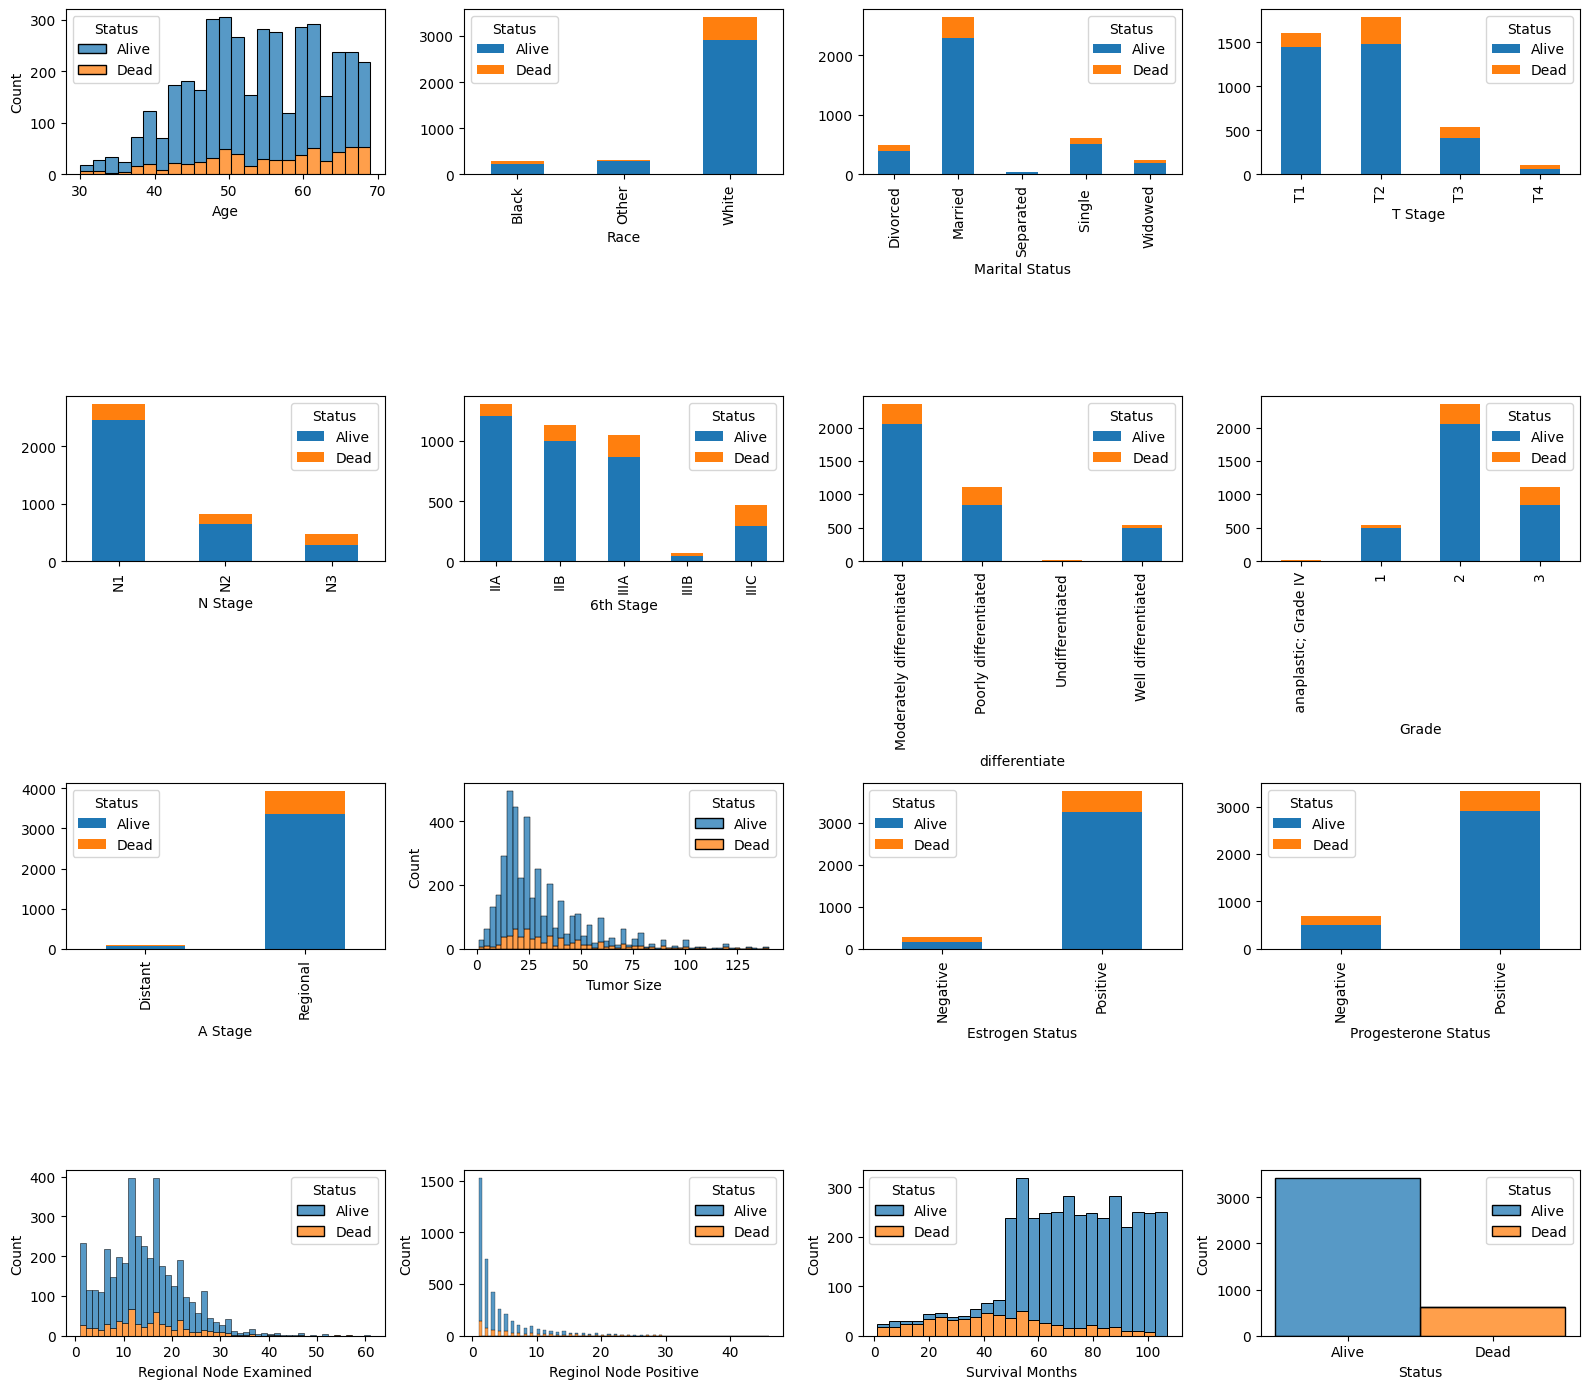

In [1414]:
fig, axes = plt.subplots(4,4,figsize=(16,14))

for i, c in enumerate(df.columns):
    ax = axes.reshape(-1)[i]
    if c in categorical_cols:
        ct = pd.crosstab(index=df[c], columns=df['Status'])
        a = ct.plot(kind='bar', stacked=True,ax=ax)
    else: 
        sns.histplot(x=c,data=df, hue='Status',ax=ax, multiple='stack')
plt.tight_layout()

## Train Test Split

In [1415]:
X = df.loc[:,df.columns != 'Status']
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


## Preprocessing

In [1416]:
def preprocessing(X, y, scaler=None):
    # We scale all the columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else: 
        X[numerical_cols] = scaler.transform(X[numerical_cols])
    # One Hot Encoding
    X = pd.get_dummies(X, columns = categorical_cols)
    # Encode output
    status_map = {'Dead': 1, 'Alive': 0}
    y = y.map(status_map)
    y = y.rename('Dead')
    return X, y, scaler

X_train, y_train, scaler = preprocessing(X_train,y_train)
X_val, y_val, _ = preprocessing(X_val, y_val, scaler)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)

## Outlier Detection

In [1417]:
# Outlier detection
joined = X_train.join(y_train)
local_outlier_factor = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
result = local_outlier_factor.fit_predict(joined[numerical_cols])
no_outliers = result == 1
joined = joined[no_outliers]
y_train = joined.pop('Dead')
X_train = joined

## Data Balancing

In [1418]:
print('Original dataset shape:', Counter(y_train))

Original dataset shape: Counter({0: 2181, 1: 394})


In [1419]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN for combined oversampling and undersampling
smote_enn = SMOTEENN(sampling_strategy='minority')
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print('Resampled dataset shape:', Counter(y_train))


Resampled dataset shape: Counter({1: 1802, 0: 1431})


## Support Functions

In [1420]:
results_df = pd.DataFrame(index=[], columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

In [1421]:
def compute_metrics(y_real,y_pred):
    accuracy = accuracy_score(y_real, y_pred)
    f1 =f1_score(y_real,y_pred, pos_label=1)
    precision = precision_score(y_real, y_pred, pos_label=1)
    recall =recall_score(y_real,y_pred, pos_label=1)
    jaccard = jaccard_score(y_real, y_pred, pos_label=1)
    return [accuracy, f1, precision, recall, jaccard]

## LDA

In [1422]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)
results_df.loc['LDA',:] = compute_metrics(y_val, y_pred_lda)
results_df

,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.824534,0.54251,0.452703,0.676768,0.372222


In [1423]:
# Exploring LDA
X_transformed = lda_model.transform(X_train)

X_transformed = pd.DataFrame(X_transformed)
X_transformed['labels'] = y_train.reset_index(drop=True)
X_transformed

,0,labels
0,-1.106613,0
1,-0.740124,0
2,-2.533290,0
3,-0.633582,0
4,-1.547505,0
...,...,...
3228,3.343725,1
3229,0.529167,1
3230,1.688218,1
3231,0.193571,1


<Axes: xlabel='0'>

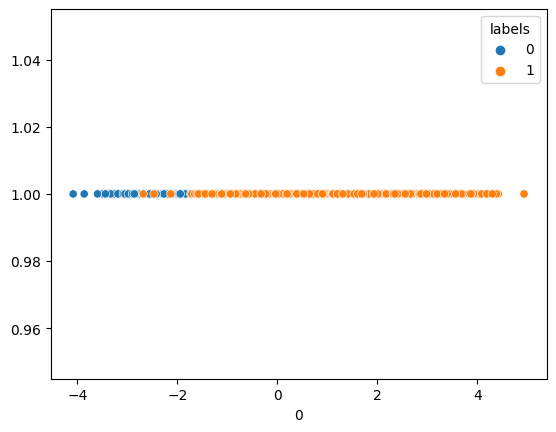

In [1424]:
sns.scatterplot(x= 0, y= 1, data = X_transformed, hue='labels')

## KNN

In [1425]:
from sklearn.neighbors import KNeighborsClassifier


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'))
results_knn = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

k_values = range(1,50,2)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn = knn.fit(X_train,y_train)
    y_pred = knn.predict(X_val)
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred)

sorted_results_knn = results_knn.sort_values(by='Recall', ascending=False)
print(sorted_results_knn)

          Accuracy        F1 Precision    Recall   Jaccard
model k                                                   
KNN   7   0.687888  0.443213  0.305344  0.808081  0.284698
      5   0.681677  0.435262  0.299242   0.79798  0.278169
      3   0.678571  0.426593  0.293893  0.777778  0.271127
      9   0.686335  0.426136  0.296443  0.757576  0.270758
      11  0.684783  0.421652  0.293651  0.747475  0.267148
      13  0.690994  0.426513  0.298387  0.747475  0.271062
      15  0.704969   0.43787  0.309623  0.747475  0.280303
      17  0.704969   0.43787  0.309623  0.747475  0.280303
      49   0.65528  0.396739  0.271375  0.737374  0.247458
      35  0.661491   0.39779  0.273764  0.727273  0.248276
      19  0.694099  0.422287  0.297521  0.727273  0.267658
      21  0.684783  0.414986  0.290323  0.727273  0.261818
      41   0.67236  0.405634   0.28125  0.727273  0.254417
      39   0.67236  0.405634   0.28125  0.727273  0.254417
      37  0.666149  0.401114  0.276923  0.727273  0.2508

In [1426]:

# Retrieve the k value of the first row
first_row = sorted_results_knn.iloc[0]
k_value = first_row.name[1]

print("k value of the first row:", k_value)

knn = KNeighborsClassifier(n_neighbors=k_value)
knn = knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_val)
results_df.loc['KNN-'+str(k_value), :] = compute_metrics(y_val, y_pred_knn)
results_df

k value of the first row: 7


,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.824534,0.54251,0.452703,0.676768,0.372222
KNN-7,0.687888,0.443213,0.305344,0.808081,0.284698


## Logistic Regression

In [1427]:
from sklearn.linear_model import LogisticRegression


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'))
results_logreg = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C, max_iter=1000, random_state=42)
    logreg = logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_val)
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred)

sorted_results_logreg = results_logreg.sort_values(by='Recall', ascending=False)
print(sorted_results_logreg)

                 Accuracy        F1 Precision    Recall   Jaccard
model  C                                                         
LogReg 0.1       0.753106  0.498423  0.362385   0.79798  0.331933
       1.0       0.790373  0.519573  0.401099  0.737374  0.350962
       10.0      0.796584  0.513011  0.405882   0.69697     0.345
       100000.0  0.799689  0.513208  0.409639  0.686869  0.345178
       10000.0   0.799689  0.513208  0.409639  0.686869  0.345178
       1000.0    0.799689  0.513208  0.409639  0.686869  0.345178
       100.0     0.799689  0.513208  0.409639  0.686869  0.345178


In [1428]:
# Retrieve the k value of the first row
first_row = sorted_results_logreg.iloc[0]
c_value = first_row.name[1]

print("c value of the first row:", c_value)

logreg = LogisticRegression(C=c_value, max_iter=1000).fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_val)
results_df.loc['LogReg-'+str(c_value), :] = compute_metrics(y_val, y_pred_logreg)

results_df.sort_values(by='Recall', ascending=False)

c value of the first row: 0.1


,Accuracy,F1,Precision,Recall,Jaccard
KNN-7,0.687888,0.443213,0.305344,0.808081,0.284698
LogReg-0.1,0.753106,0.498423,0.362385,0.79798,0.331933
LDA,0.824534,0.54251,0.452703,0.676768,0.372222


## Random Forest

In [1429]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]   # Minimum number of samples required to split an internal node
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring='recall',
                           cv=5,
                           refit='recall')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Print the best score found by GridSearchCV
print("Best Score:", grid_search.best_score_)

# Get the best model found by GridSearchCV
best_rfmodel = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.9789042782394584


In [1430]:
y_pred_rf = best_rfmodel.predict(X_val)
results_df.loc['Random Forest', :] = compute_metrics(y_val, y_pred_rf)

results_df.sort_values(by='Recall', ascending=False)

,Accuracy,F1,Precision,Recall,Jaccard
KNN-7,0.687888,0.443213,0.305344,0.808081,0.284698
LogReg-0.1,0.753106,0.498423,0.362385,0.79798,0.331933
Random Forest,0.790373,0.509091,0.397727,0.707071,0.341463
LDA,0.824534,0.54251,0.452703,0.676768,0.372222


## Feature Importance

<Axes: >

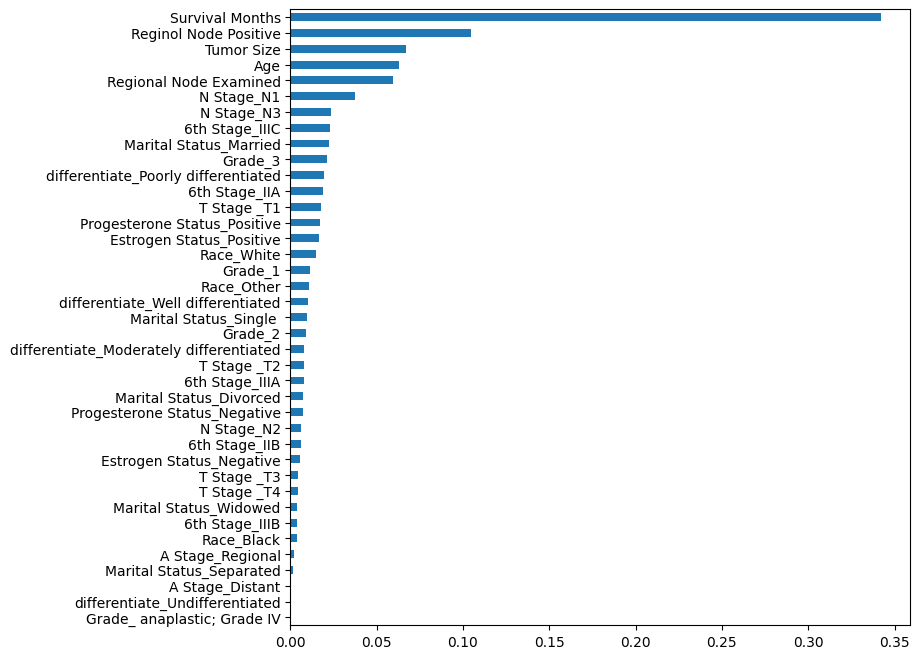

In [1431]:
var_imp = pd.DataFrame({'importance': best_rfmodel.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False)

## Generalization Performance

In [1432]:
logreg = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
logreg = logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

In [1433]:
print('accuracy_score: ',accuracy_score(y_test,y_pred))
print('recall_score: ',recall_score(y_test,y_pred))
print('jaccard_score: ',jaccard_score(y_test,y_pred))
print('f1_score: ',f1_score(y_test,y_pred))
print('precision_score: ',precision_score(y_test,y_pred))

fig = px.imshow(np.around(confusion_matrix(y_test, y_pred, normalize='true'),2), 
                template='ggplot2',
                text_auto=True, 
                aspect="True", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")
fig.show()

accuracy_score:  0.7391304347826086
recall_score:  0.7479674796747967
jaccard_score:  0.304635761589404
f1_score:  0.46700507614213205
precision_score:  0.33948339483394835
